In [87]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer

In [89]:
# Load Data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [91]:
# Basic Preprocessing
train = train.drop(columns=['Cabin', 'Ticket', 'Name', 'PassengerId'])
train['Age'].fillna(train['Age'].median(), inplace=True)
train['Embarked'].fillna(train['Embarked'].mode()[0], inplace=True)


C:\Users\jayak\AppData\Local\Temp\ipykernel_8508\1446223874.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['Age'].fillna(train['Age'].median(), inplace=True)
C:\Users\jayak\AppData\Local\Temp\ipykernel_8508\1446223874.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

F

In [93]:
# Features & Target
X = train.drop(columns='Survived')
y = train['Survived']

In [95]:
# Column Categories
numeric_features = ['Age', 'Fare', 'SibSp', 'Parch']
categorical_features = ['Sex', 'Embarked', 'Pclass']

In [97]:
# Preprocessing Pipelines
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [99]:
# Models to Compare
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier( eval_metric='logloss', random_state=42)
}

In [101]:
# Model Evaluation Loop
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
    print(f"{name} Accuracy (CV): {scores.mean():.4f}")

Random Forest Accuracy (CV): 0.8081
Gradient Boosting Accuracy (CV): 0.8261
XGBoost Accuracy (CV): 0.8171


In [102]:
# Fit best model for Feature Importance (Random Forest example)
best_model = RandomForestClassifier(n_estimators=100, random_state=42)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', best_model)
])
pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'Fare', 'SibSp',
                                                   'Parch']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Sex', 'Embarked',
                                                   'Pclass'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [103]:
# Get feature names after OneHotEncoding
ohe = pipeline.named_steps['preprocessor'].named_transformers_['cat']
cat_feature_names = ohe.get_feature_names_out(categorical_features)
all_features = numeric_features + list(cat_feature_names)

In [107]:
# Extract feature importances
importances = pipeline.named_steps['classifier'].feature_importances_
importance_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

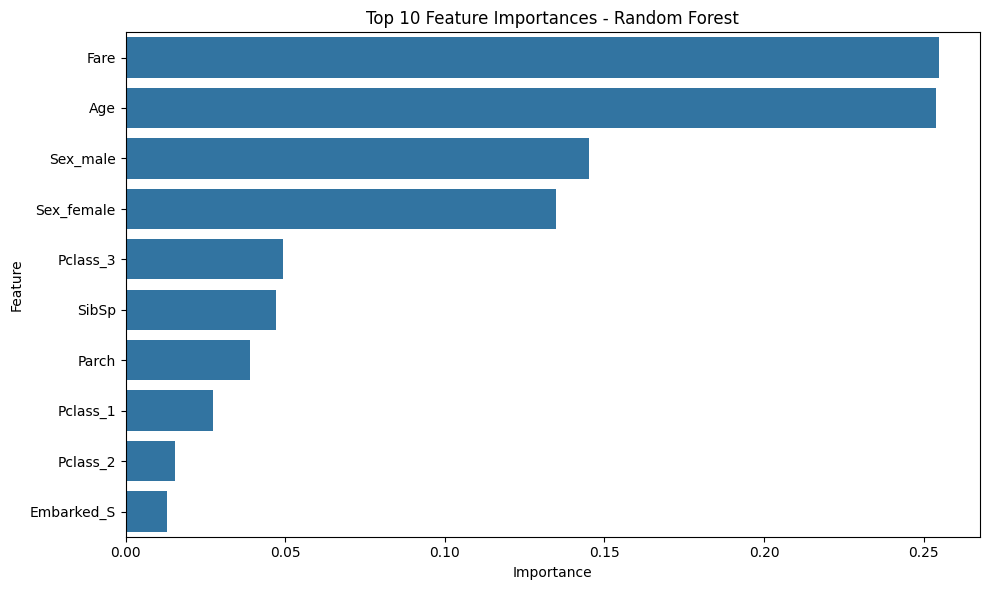

In [109]:
# Plot Top 10 Feature Importances
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(10), x='Importance', y='Feature')
plt.title("Top 10 Feature Importances - Random Forest")
plt.tight_layout()
plt.show()